In [1]:
import Database_connector
import pandas as pd
from scipy import stats
from Support_functions import agent_to_data_frame
from psycopg2.extensions import AsIs
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.style.use('fast')
import seaborn as sns

In [2]:
limit_days_from = 0
limit_days_to = 300

In [3]:
scenarios = pd.read_excel("Input/scenarios.xlsx")
scenarios

,Scenario,Inventory management,Main priority
0,scenario_1,Naive estimation,Cost minimization
1,scenario_2,Naive estimation,Lead time minimization
2,scenario_3,Naive estimation,Maximize delivery on time
3,scenario_4,Naive estimation and buffer based on machine l...,Cost minimization
4,scenario_5,Naive estimation and buffer based on machine l...,Lead time minimization
5,scenario_6,Naive estimation and buffer based on machine l...,Maximize delivery on time
6,scenario_7,Naive estimation and DDMRP buffer,Cost minimization
7,scenario_8,Naive estimation and DDMRP buffer,Lead time minimization
8,scenario_9,Naive estimation and DDMRP buffer,Maximize delivery on time


In [4]:
database_title_list = scenarios['Scenario'].tolist()

In [5]:
df_all = pd.DataFrame()

for database_title in database_title_list:
    db = Database_connector.MyDatabase()
    db.create_con(database_title = database_title, user="postgres", port = 5432, password = "admin", host = 'localhost')
    df = db.table_to_df('kpi_table')
    df = df.drop(columns=['id'])
    df['Scenario_ID'] = database_title
    
    df_all = df_all.append(df,ignore_index=True)
    
df_all = df_all[df_all['day'] > limit_days_from]
df_all = df_all[df_all['day'] < limit_days_to]

In [6]:
col_names = ['total_orders', 'total_inventory', 'backlog', 'order_fulfilment',
       'revenue', 'cost_of_production', 'costs_of_raw_material',
       'cost_of_delivery', 'costs_of_storage', 'profit']

In [7]:
df_all.to_csv('Input\KPI.csv', index = False)
df_all[col_names] = df_all[col_names].apply(pd.to_numeric)
df_all

,day,total_orders,total_inventory,backlog,order_fulfilment,revenue,cost_of_production,costs_of_raw_material,cost_of_delivery,costs_of_storage,profit,Scenario_ID
1,1,107,2280,0,1.00,128468,0,0,0,4559,123909,scenario_1
2,2,96,2183,0,1.00,115782,0,0,0,4366,111416,scenario_1
3,3,89,2094,0,1.00,107262,0,0,0,4188,103074,scenario_1
4,4,92,2002,0,1.00,110528,0,0,0,4003,106525,scenario_1
5,5,86,1915,0,1.00,103842,0,0,0,3830,100012,scenario_1
...,...,...,...,...,...,...,...,...,...,...,...,...
4602,295,82,1525,7,0.91,88928,0,0,0,3051,85877,scenario_9
4603,296,85,1450,9,0.89,89820,0,0,0,2901,86919,scenario_9
4604,297,75,1385,9,0.88,78720,8293,0,0,2770,67657,scenario_9
4605,298,81,1412,11,0.86,82774,29330,0,0,2824,50620,scenario_9


# Descriptive statistics

In [8]:
df_mean = (df_all.groupby('Scenario_ID').mean())
df_mean.reset_index(inplace = True) 
df_mean = pd.melt(df_mean, id_vars=["Scenario_ID"])
df_mean.columns = ['Scenario_ID', 'Indicator', 'Mean']
df_std = (df_all.groupby('Scenario_ID').std())
df_std.reset_index(inplace = True) 
df_std = pd.melt(df_std, id_vars=["Scenario_ID"])
df_std.columns = ['Scenario_ID', 'Indicator', 'std']
df_statistics = df_mean.merge(df_std, on = ['Scenario_ID', 'Indicator'])
df_statistics = df_statistics[df_statistics['Indicator'] != 'day']
df_statistics.to_excel('Output\statistics.xlsx', index = False)
df_statistics

,Scenario_ID,Indicator,Mean,std
9,scenario_1,total_orders,79.675585,4.535295
10,scenario_2,total_orders,80.026756,4.460034
11,scenario_3,total_orders,80.026756,4.460034
12,scenario_4,total_orders,79.675585,4.535295
13,scenario_5,total_orders,80.026756,4.460034
...,...,...,...,...
94,scenario_5,profit,73135.484950,20434.385271
95,scenario_6,profit,74437.211470,20510.861034
96,scenario_7,profit,73339.448161,34834.496766
97,scenario_8,profit,74702.976589,17445.469197


# Lead time

In [9]:
database_title = 'scenario_1'
db = Database_connector.MyDatabase()
db.create_con(database_title = database_title, user="postgres", port = 5432, password = "admin", host = 'localhost')
df = db.table_to_df('lead_time_history')
df = df[['day', 'lead_time', 'supplier_id']]
df['Country'] = df['supplier_id'].str.split('_',expand=True)[1]
df.loc[df['Country'] == 'C', 'Country'] = 'Long route'
df.loc[df['Country'] != 'Long route', 'Country'] = 'Short route'
df = (df.groupby(['day', 'Country']).mean())
df.reset_index(inplace = True) 
df['lead_time'] = df['lead_time'].astype(int)
df = df.rename(columns={"Country": "Type"})
df = df.rename(columns={"lead_time": "Average lead time"})
df = df[df['day'] > limit_days_from]
df = df[df['day'] < limit_days_to]
df

,day,Type,Average lead time
2,1,Long route,15
3,1,Short route,3
4,2,Long route,16
5,2,Short route,3
6,3,Long route,16
...,...,...,...
595,297,Short route,3
596,298,Long route,14
597,298,Short route,3
598,299,Long route,13


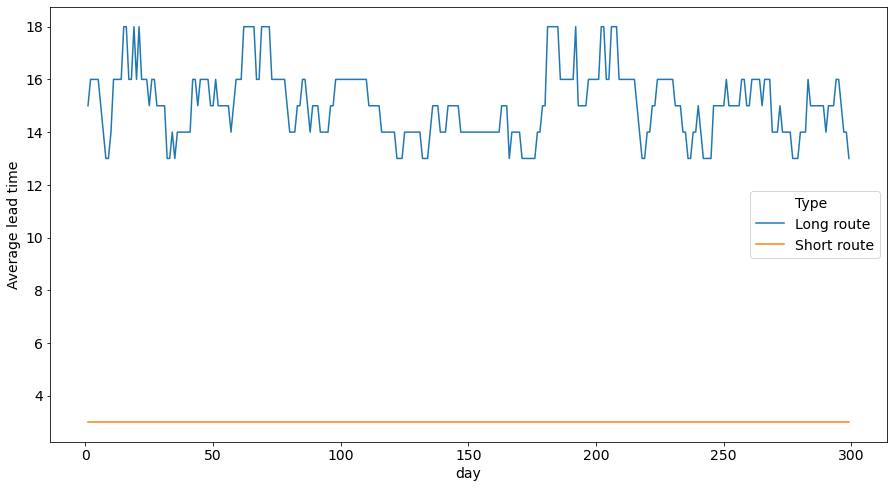

In [10]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x='day', 
             y='Average lead time',
             hue='Type',
             data=df)
plt.savefig('Output/Lead time.jpg')

# Comparison of inventory levels

In [11]:
df_all = pd.DataFrame()

for database_title in database_title_list:
    db = Database_connector.MyDatabase()
    db.create_con(database_title = database_title, user="postgres", port = 5432, password = "admin", host = 'localhost')
    df = db.table_to_df('retail_inventory')
    df['Scenario_ID'] = database_title
    df = df.drop(columns=['id'])
    df_all = df_all.append(df,ignore_index=True)
    
df_all = df_all[df_all['day'] > limit_days_from]
df_all = df_all[df_all['day'] < limit_days_to]

In [12]:
df_inventory = (df_all.groupby('Scenario_ID').sum())
df_inventory.reset_index(inplace = True) 
df_inventory.to_excel('Output\Inventory level comparison - total sum.xlsx', index = False)
df_inventory

,Scenario_ID,day,stock_level,order_size,estimated_order,backlog,units_sold,storage_costs,revenue
0,scenario_1,3139500,23555487,1677732,1580181,289108,1382842,47103768,1655839800
1,scenario_2,3139500,31465120,1685130,1594115,172198,1506750,62922853,1804317600
2,scenario_3,3139500,32207845,1685130,1600012,169232,1509722,64408106,1807885800
3,scenario_4,3139500,28949961,1677732,1647258,332503,1339618,57892903,1604077800
4,scenario_5,3139500,46065755,1685130,1679818,182888,1496188,92124084,1791734400
5,scenario_6,3035550,40437544,1572961,1651601,156482,1410735,80868031,1689383400
6,scenario_7,3139500,29398938,1677732,1759233,221551,1450163,58790302,1736494200
7,scenario_8,3139500,40438662,1685130,1776213,163778,1515197,80869605,1814480400
8,scenario_9,3139500,40758739,1685130,1774596,149044,1529873,81509772,1832061000


In [13]:
df_all = pd.DataFrame()

for database_title in database_title_list:
    db = Database_connector.MyDatabase()
    db.create_con(database_title = database_title, user="postgres", port = 5432, password = "admin", host = 'localhost')
    df = db.table_to_df('production_inventory')
    df = df[['costs_of_production', 'day']]
    df['Scenario_ID'] = database_title
    
    df_all = df_all.append(df,ignore_index=True)
    
df_all = df_all[df_all['day'] > limit_days_from]
df_all = df_all[df_all['day'] < limit_days_to]
df_all = df_all.drop(columns=['day'])

In [14]:
df_production = (df_all.groupby('Scenario_ID').sum())
df_production.reset_index(inplace = True) 
df_production

,Scenario_ID,costs_of_production
0,scenario_1,298743600
1,scenario_2,351396960
2,scenario_3,354283200
3,scenario_4,292305360
4,scenario_5,352077120
5,scenario_6,321249120
6,scenario_7,316125840
7,scenario_8,355062960
8,scenario_9,358035840


In [15]:
df_all = pd.DataFrame()

for database_title in database_title_list:
    db = Database_connector.MyDatabase()
    db.create_con(database_title = database_title, user="postgres", port = 5432, password = "admin", host = 'localhost')
    df = db.table_to_df('product_orders')
    df = df[['cost_of_transportation', 'day']]
    df['Scenario_ID'] = database_title
    
    df_all = df_all.append(df,ignore_index=True)

df_all = df_all[df_all['day'] > limit_days_from]
df_all = df_all[df_all['day'] < limit_days_to]
df_all = df_all.drop(columns=['day'])

In [16]:
df_products = (df_all.groupby('Scenario_ID').sum())
df_products.columns = ['Costs of product transportation']
df_products.reset_index(inplace = True) 
df_products

,Scenario_ID,Costs of product transportation
0,scenario_1,435675
1,scenario_2,1821267
2,scenario_3,1821267
3,scenario_4,489185
4,scenario_5,1821267
5,scenario_6,1787729
6,scenario_7,433635
7,scenario_8,1821267
8,scenario_9,1821267


In [17]:
df_all = pd.DataFrame()

for database_title in database_title_list:
    db = Database_connector.MyDatabase()
    db.create_con(database_title = database_title, user="postgres", port = 5432, password = "admin", host = 'localhost')
    df = db.table_to_df('raw_material_orders')
    df = df[['costs_of_raw_materials', 'cost_of_transportation', 'day']]
    df['Scenario_ID'] = database_title
    
    df_all = df_all.append(df,ignore_index=True)
                           
df_all = df_all[df_all['day'] > limit_days_from]
df_all = df_all[df_all['day'] < limit_days_to]
df_all = df_all.drop(columns=['day'])

In [18]:
df_raw_material = (df_all.groupby('Scenario_ID').sum())
df_raw_material.columns = ['Costs of raw materials', 'Costs of raw material transportation']
df_raw_material.reset_index(inplace = True) 
df_raw_material

,Scenario_ID,Costs of raw materials,Costs of raw material transportation
0,scenario_1,137275027,46954764
1,scenario_2,348285706,7749000
2,scenario_3,350591589,7749000
3,scenario_4,119738149,44212458
4,scenario_5,336312144,7749000
5,scenario_6,327255930,7600569
6,scenario_7,137265815,47250000
7,scenario_8,343945065,7749000
8,scenario_9,346743906,7749000


In [19]:
df_profit = df_inventory[['storage_costs', 'revenue', 'Scenario_ID']]
df_profit = df_profit.merge(df_production, on = 'Scenario_ID')
df_profit = df_profit.merge(df_products, on = 'Scenario_ID')
df_profit = df_profit.merge(df_raw_material, on = 'Scenario_ID')
df_profit

,storage_costs,revenue,Scenario_ID,costs_of_production,Costs of product transportation,Costs of raw materials,Costs of raw material transportation
0,47103768,1655839800,scenario_1,298743600,435675,137275027,46954764
1,62922853,1804317600,scenario_2,351396960,1821267,348285706,7749000
2,64408106,1807885800,scenario_3,354283200,1821267,350591589,7749000
3,57892903,1604077800,scenario_4,292305360,489185,119738149,44212458
4,92124084,1791734400,scenario_5,352077120,1821267,336312144,7749000
5,80868031,1689383400,scenario_6,321249120,1787729,327255930,7600569
6,58790302,1736494200,scenario_7,316125840,433635,137265815,47250000
7,80869605,1814480400,scenario_8,355062960,1821267,343945065,7749000
8,81509772,1832061000,scenario_9,358035840,1821267,346743906,7749000


In [20]:
df_profit['Total costs'] = df_profit['storage_costs'] + df_profit['costs_of_production'] + df_profit['Costs of product transportation'] + df_profit['Costs of raw materials'] + df_profit['Costs of raw material transportation']
df_profit['Profit'] = df_profit['revenue'] - df_profit['Total costs']
df_profit.to_excel("Output\Total comparison.xlsx", index = False)
df_profit

,storage_costs,revenue,Scenario_ID,costs_of_production,Costs of product transportation,Costs of raw materials,Costs of raw material transportation,Total costs,Profit
0,47103768,1655839800,scenario_1,298743600,435675,137275027,46954764,530512834,1125326966
1,62922853,1804317600,scenario_2,351396960,1821267,348285706,7749000,772175786,1032141814
2,64408106,1807885800,scenario_3,354283200,1821267,350591589,7749000,778853162,1029032638
3,57892903,1604077800,scenario_4,292305360,489185,119738149,44212458,514638055,1089439745
4,92124084,1791734400,scenario_5,352077120,1821267,336312144,7749000,790083615,1001650785
5,80868031,1689383400,scenario_6,321249120,1787729,327255930,7600569,738761379,950622021
6,58790302,1736494200,scenario_7,316125840,433635,137265815,47250000,559865592,1176628608
7,80869605,1814480400,scenario_8,355062960,1821267,343945065,7749000,789447897,1025032503
8,81509772,1832061000,scenario_9,358035840,1821267,346743906,7749000,795859785,1036201215


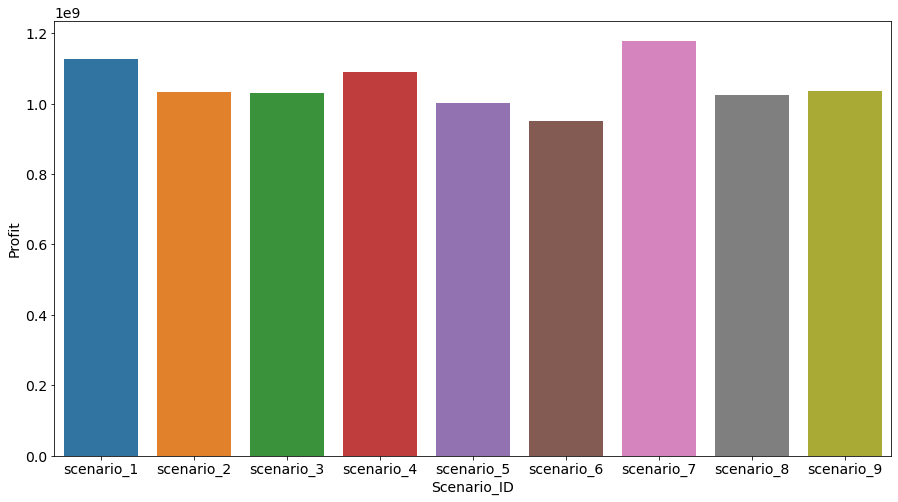

In [21]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x='Scenario_ID', 
             y='Profit',
             data=df_profit)
plt.savefig('Output/Total profit comparison.jpg')